In [1]:
%matplotlib inline
import sparseSpACE
from sparseSpACE.Function import *
from sparseSpACE.StandardCombi import *
from sparseSpACE.Grid import *
import numpy as np


## Clenshaw-Curtis Grid


In [2]:
dim = 8
coeffs = np.ones(dim)*5
midpoint = np.ones(dim)*0.5
a = np.zeros(dim)
b = np.ones(dim)
grid = GaussLegendreGrid(a=a, b=b)
f = GenzDiscontinious(coeffs, midpoint)

# NEW! define operation which shall be performed in the combination technique
from sparseSpACE.GridOperation import *
operation = Integration(f=f, grid=grid, dim=dim, reference_solution = f.getAnalyticSolutionIntegral(a,b))
combiObject = StandardCombi(a, b, operation=operation)
minimum_level = 1
maximum_level = 5
combiObject.perform_operation(minimum_level, maximum_level, f)
#combiObject.print_resulting_combi_scheme()
#combiObject.print_resulting_sparsegrid()

Combi scheme:
Cannot print combischeme of dimension > 2
Sparse Grid:
Cannot print sparse grid of dimension > 3
Time used (s):59.92201566199992
Number of distinct points used during the refinement (StdCombi): 14156289
Analytic Solution: 1.2902079262895528e-06 
Difference 2.3959431008899744e-07: 


([<sparseSpACE.ComponentGridInfo.ComponentGridInfo at 0x7fb957a5e700>,
 2.3959431008899744e-07,
 array([1.05061362e-06]))

In [3]:
GenzDiscontinious??

Init signature: GenzDiscontinious(coeffs, border)
Docstring:      <no docstring>
Source:        
class GenzDiscontinious(Function):
    def __init__(self, coeffs, border):
        super().__init__()
        self.coeffs = coeffs
        self.border = border
        self.dim = len(coeffs)

    def eval(self, coordinates):
        result = 0
        for d in range(self.dim):
            if coordinates[d] >= self.border[d]:
                return 0.0
            result -= self.coeffs[d] * coordinates[d]
        return np.exp(result)

    def eval_vectorized(self, coordinates: Sequence[Sequence[float]]):
        result = np.zeros(np.shape(coordinates)[:-1])
        filter = np.all(coordinates < self.border, axis=-1)
        result[filter] = np.exp(-1 * np.inner(coordinates[filter], self.coeffs))
        self.check_vectorization(coordinates, result)
        return result

    def getAnalyticSolutionIntegral(self, start, end):
        result = 1
        end = list(end)
        for d in range(

## Gauss-Legendre Grid

Combi scheme:
Cannot print combischeme of dimension > 2
Sparse Grid:


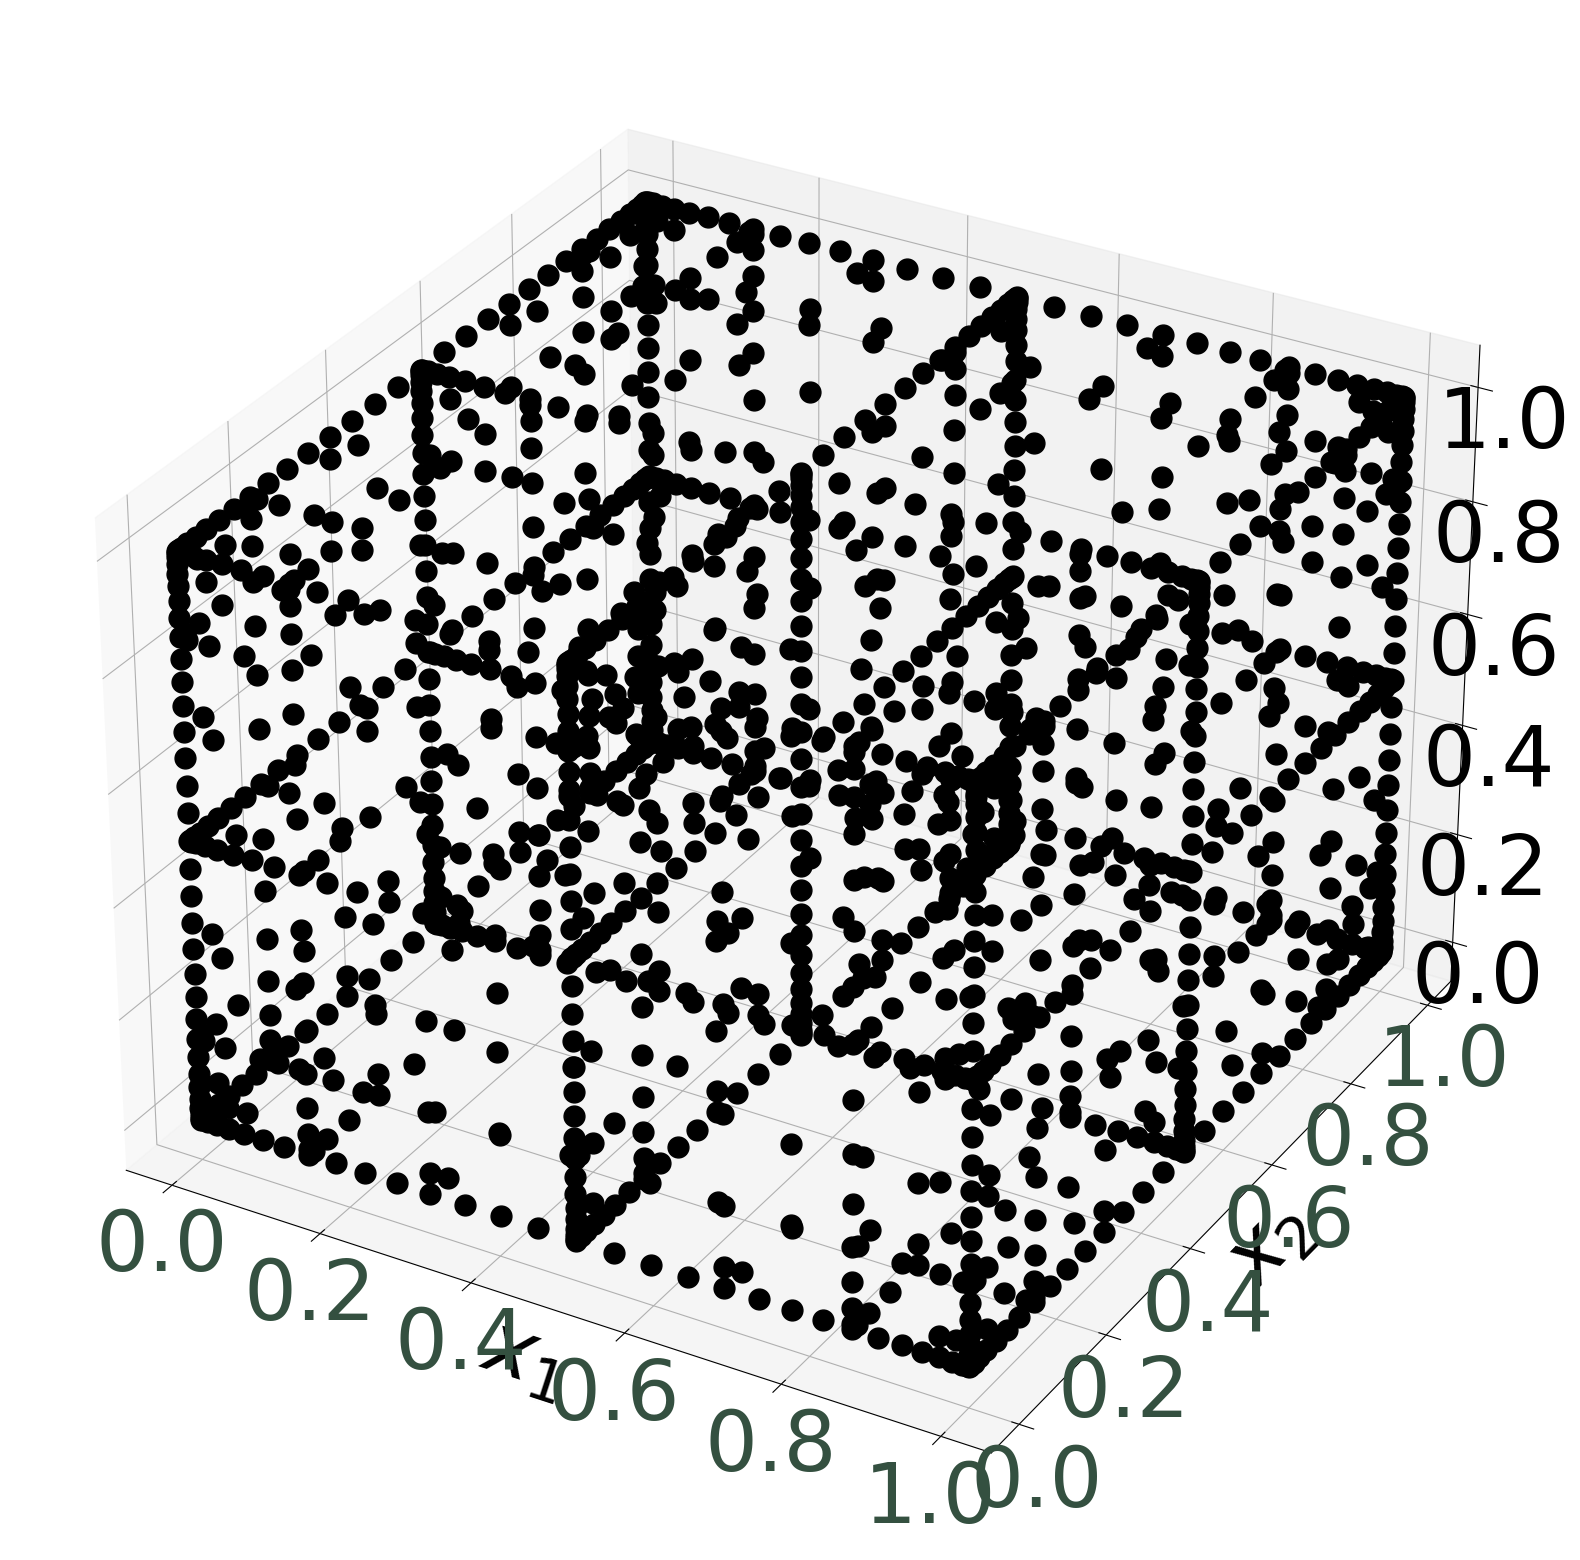

Time used (s):0.28971217800017257
Number of distinct points used during the refinement (StdCombi): 1505
Analytic Solution: -0.06235931799348836 
Difference 5.065392549852277e-16: 


([<sparseSpACE.ComponentGridInfo.ComponentGridInfo at 0x7fb94f969580>,
 5.065392549852277e-16,
 array([-0.06235932]))

In [18]:
dim = 3
coeffs = np.ones(dim)
offset = 0.5
a = np.zeros(dim)
b = np.ones(dim)
grid = ClenshawCurtisGrid(a=a, b=b)
f = GenzOszillatory(coeffs=coeffs, offset=offset)
reference_solution = f.getAnalyticSolutionIntegral(a,b)

# NEW! define operation which shall be performed in the combination technique
from sparseSpACE.GridOperation import *
operation = Integration(f=f, grid=grid, dim=dim, reference_solution=reference_solution)
combiObject = StandardCombi(a, b, operation=operation, log_level=log_levels.WARNING)
minimum_level = 1
maximum_level = 5
combiObject.perform_operation(minimum_level, maximum_level, f)

## Spatially Adaptive Combination

In [21]:
from sparseSpACE.spatiallyAdaptiveCell import *
from sparseSpACE.Function import *
from sparseSpACE.ErrorCalculator import *
from sparseSpACE.GridOperation import *
#dimension of the problem
dim = 2
# define function to be integrated
coeffs = np.ones(dim)*5
#midpoint = np.ones(dim)*0.5
offset = 0.5
a = np.zeros(dim)
b = np.ones(dim)
grid = GaussLegendreGrid(a=a, b=b)
f = GenzOszillatory(coeffs, offset)
# plot function
#f.plot(np.ones(dim)*a,np.ones(dim)*b)

# reference integral solution for calculating errors
reference_solution = f.getAnalyticSolutionIntegral(a,b)

# define error estimator for refinement
errorOperator=ErrorCalculatorSurplusCell()

# NEW! define operation which shall be performed in the combination technique
operation = Integration(f=f, grid=grid, dim=dim, reference_solution = reference_solution, print_level=0)

# define Cell refinement strategy for Spatially Adaptive Combination Technique
adaptiveCombiInstanceCell = SpatiallyAdaptiveCellScheme(a, b, operation=operation)

# the cell method does not have component grids and therefore the sparse grid is printed twice per iteration!
# performing the spatially adaptive refinement with the Cell method
adaptiveCombiInstanceCell.performSpatiallyAdaptiv(2, 2, errorOperator, 10**-2, do_plot=False, print_output=False)

print("Number of points used in refinement:", adaptiveCombiInstanceCell.get_total_num_points())

split dimension 0
split dimension 0
split dimension 1
split dimension 1
Current number of function evaluations 9
combiintegral: -0.04714114877797798
Finished refinement
Refined 1 times
Current number of function evaluations 13
combiintegral: -0.05671724459386566
Finished refinement
Refined 1 times
Current number of function evaluations 17
combiintegral: -0.04885516084532942
Finished refinement
Refined 2 times
Current number of function evaluations 21
combiintegral: -0.02768156011200278
Finished refinement
Refined 4 times
Current number of function evaluations 29
combiintegral: -0.06440303041141407
Finished refinement
Refined 3 times
Current number of function evaluations 31
combiintegral: -0.07299622269292046
Finished refinement
Refined 2 times
Current number of function evaluations 33
combiintegral: -0.03783953557694773
Finished refinement
Refined 1 times
Current number of function evaluations 33
combiintegral: -0.024057334681183536
Finished refinement
Refined 6 times
Current number o

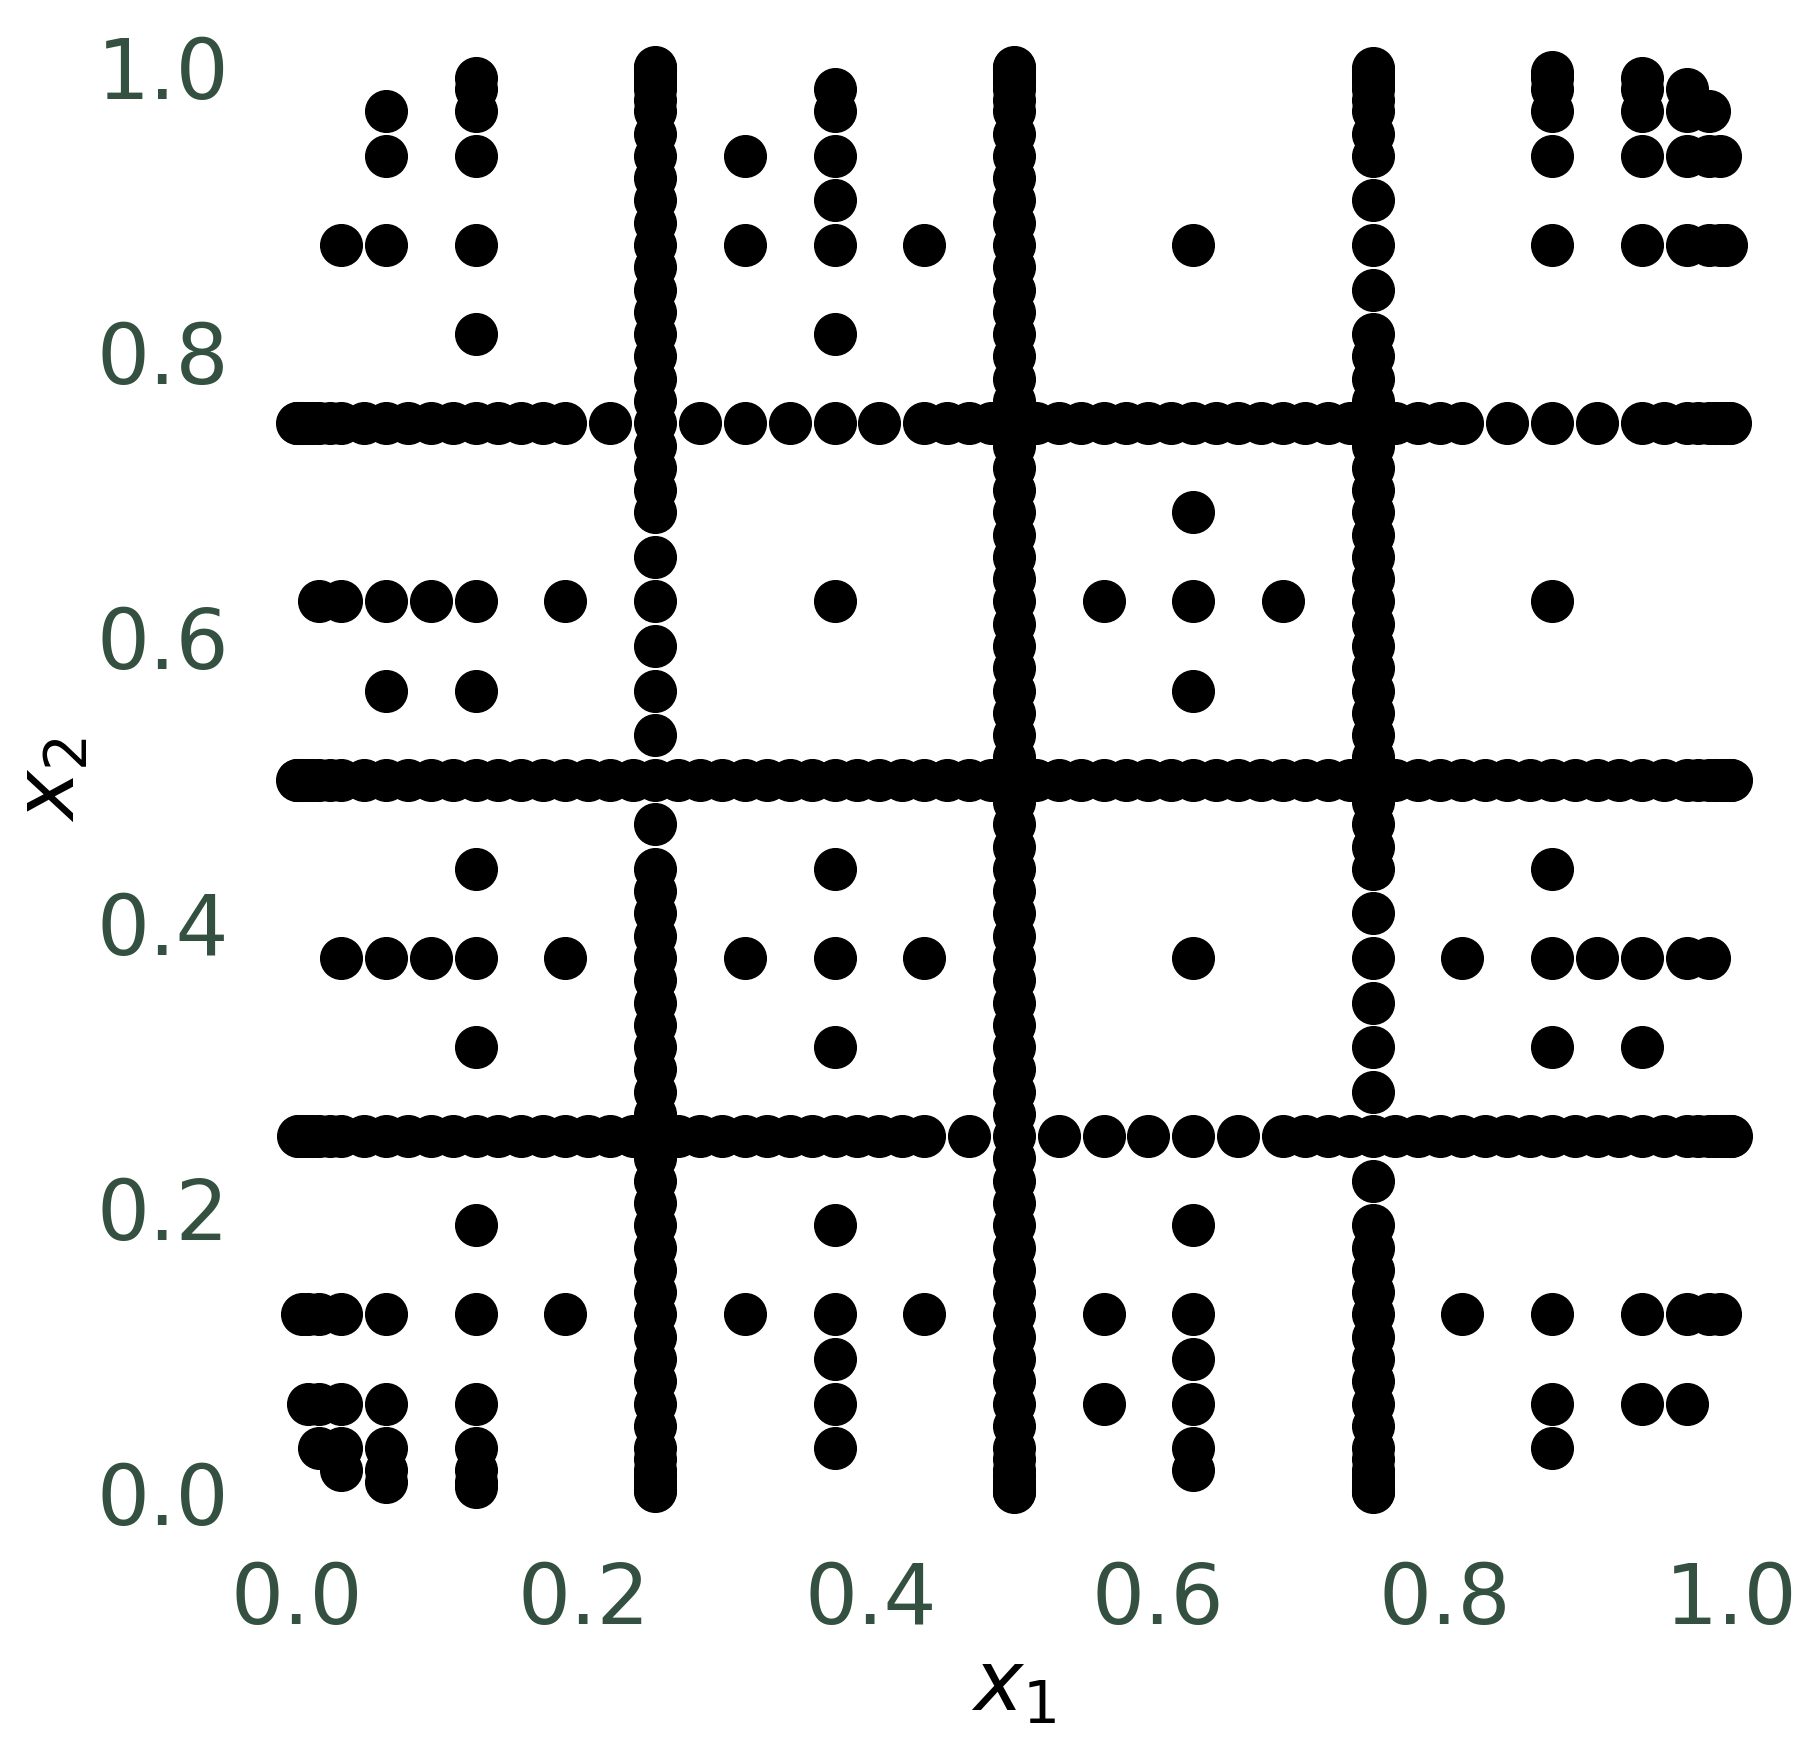

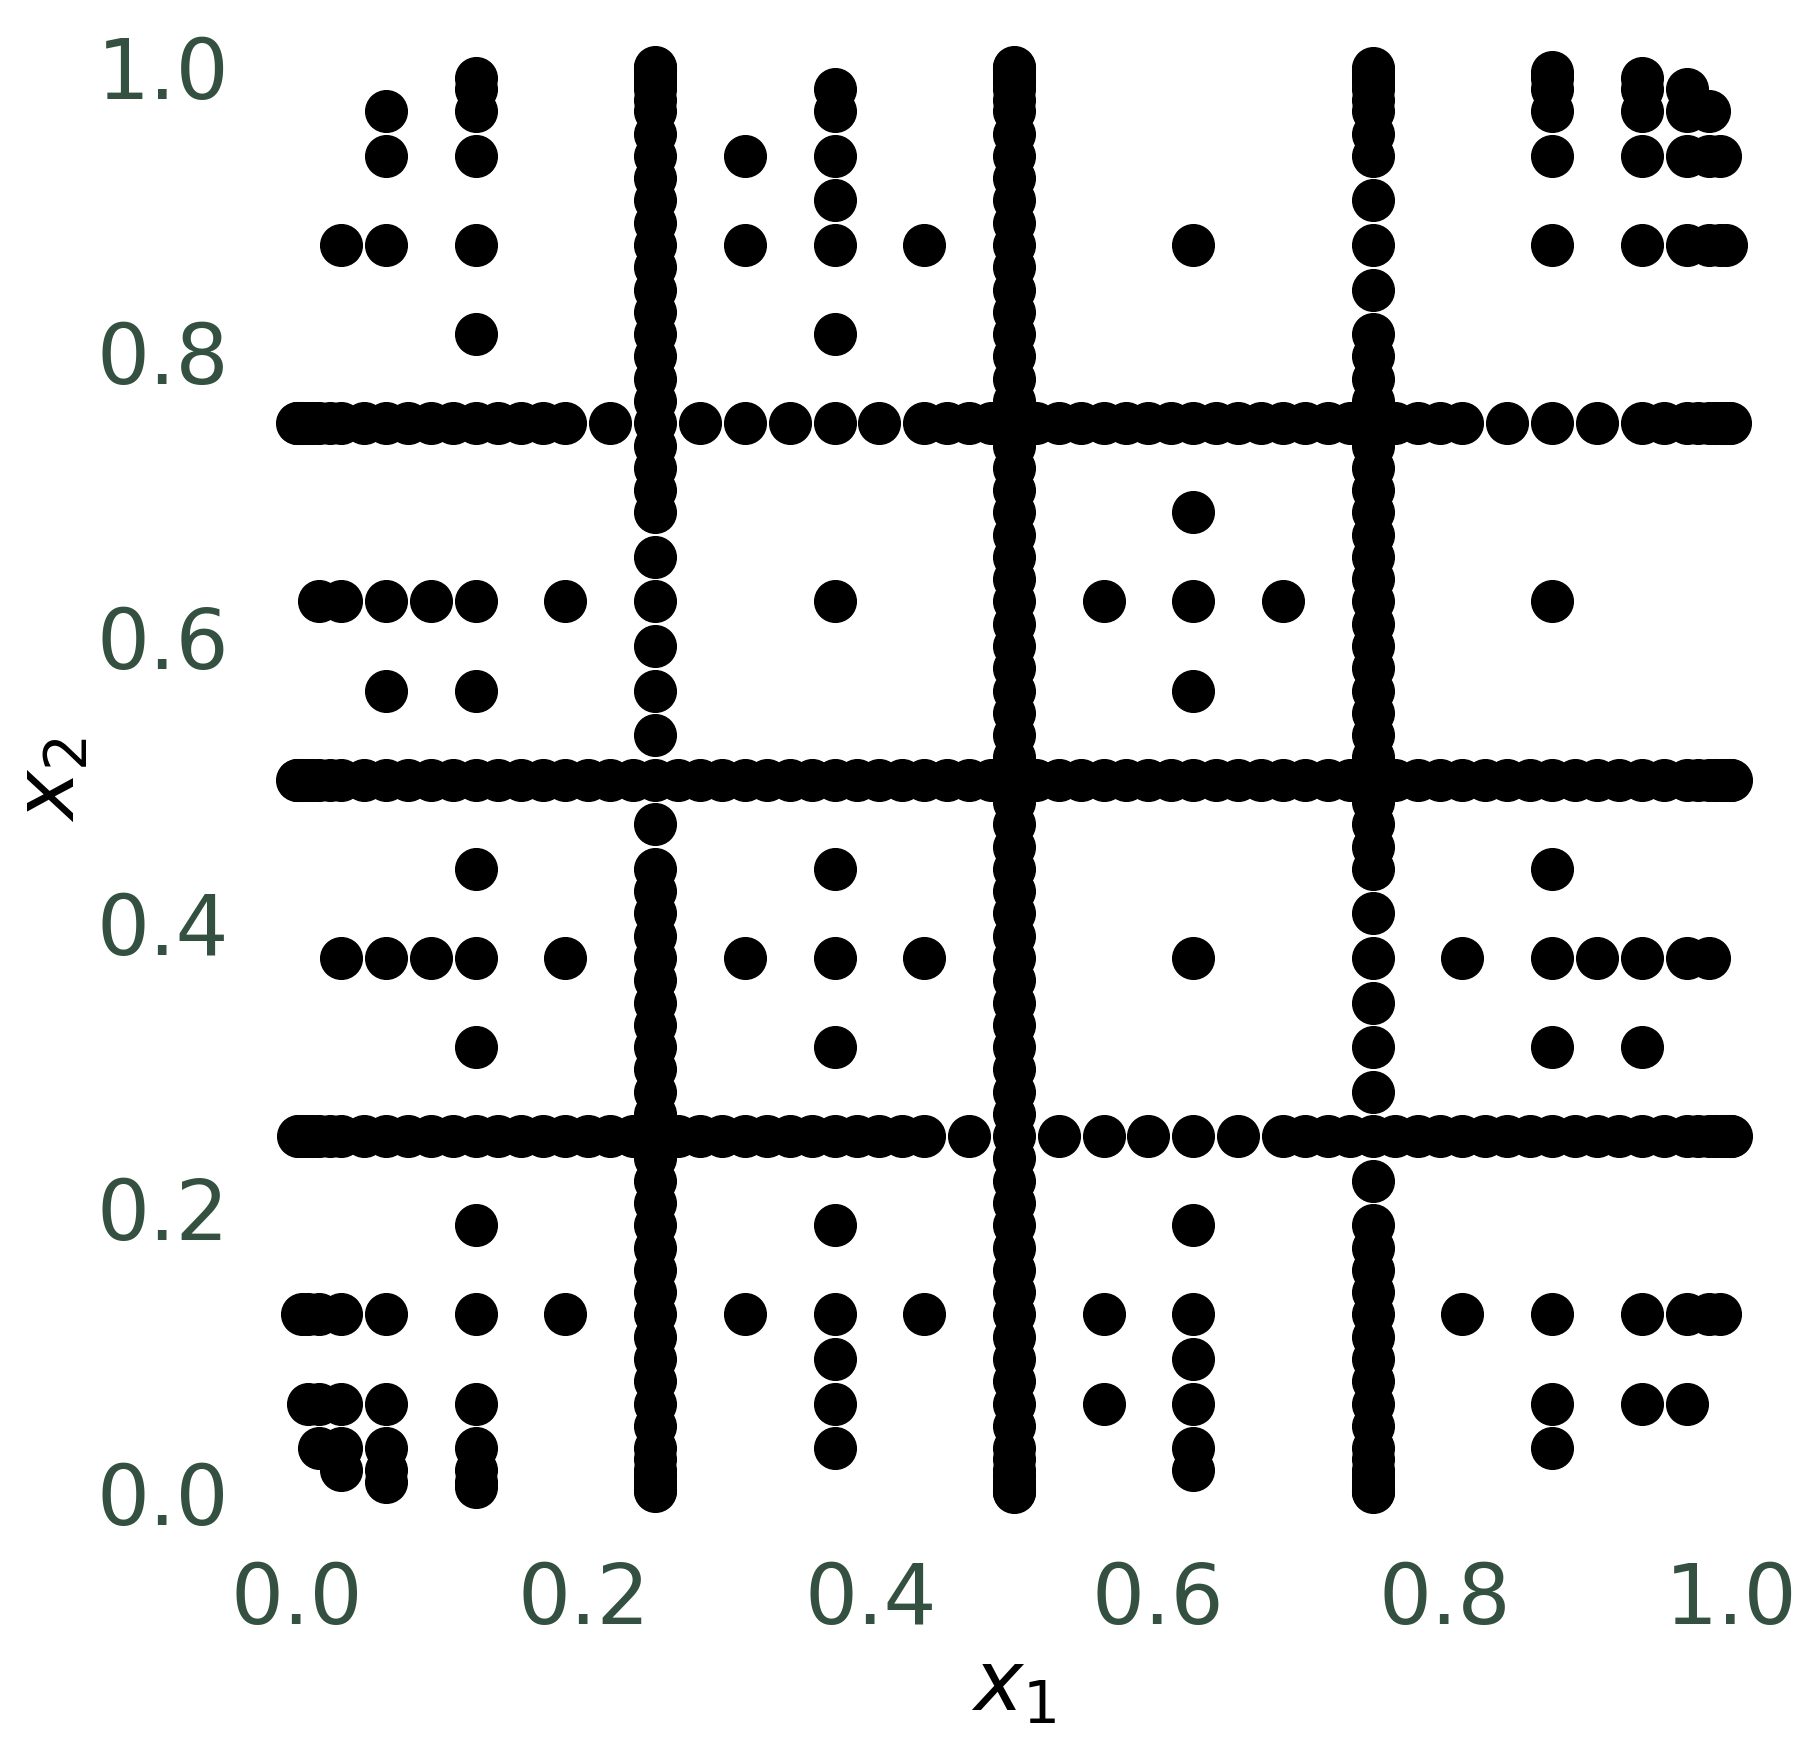

In [22]:
adaptiveCombiInstanceCell.print_resulting_sparsegrid()